<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/baseflow-notebooks/blob/main/baseflow_multi_station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***In this notebook, we will demonstrate how to use the baseflow package to perform baseflow separation on streamflow data obtained from multiple stations.***

Workflow:
 * Data Acquisition: Fetch streamflow data from the USGS API or upload your own data files.
 * Data Preparation: Prepare the data for analysis, including converting timestamps and handling missing values.
 * Baseflow Separation: Apply various baseflow separation methods provided by the baseflow package to each station's data.
 * Result Analysis: Visualize the separated baseflow components and calculate performance metrics for each station.

***By the end of this notebook, you will have a comprehensive understanding of how to perform baseflow separation for multiple stations using the baseflow package and analyze the results effectively.***

# Install baseflow package from github

In [2]:
!pip install git+https://github.com/BYU-Hydroinformatics/baseflow.git

  Cloning https://github.com/BYU-Hydroinformatics/baseflow.git to /tmp/pip-req-build-qj8_9600
  Running command git clone --filter=blob:none --quiet https://github.com/BYU-Hydroinformatics/baseflow.git /tmp/pip-req-build-qj8_9600
  Resolved https://github.com/BYU-Hydroinformatics/baseflow.git to commit 50a60ee97f9132f06a30b454ab0d8c5eb4dab97d
  Preparing metadata (setup.py) ... done
  Created wheel for baseflow: filename=baseflow-0.0.9-py3-none-any.whl size=101938 sha256=a16d881ec53889d8cc67dbea1dac2decd7a210de5ef7d81aca5aacb9fc4ae6a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dw0gpbi4/wheels/f4/6d/fe/c937a4db1017b5070652dfe2b4841589a4aca8cff895ae4abe
Successfully built baseflow


# Load necessary packages

In [3]:
import baseflow
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import urllib.parse
import urllib.request
import os
import numpy as np
from numba import njit, prange

# Download flow data from USGS

This part of the code essentially automates the process of fetching streamflow data for a specific station and time period from the USGS website. It prepares the data for further processing and analysis in the subsequent steps of your notebook.

This part includes:

*   Specify Parameters: You define the station_number, start_date, and end_date to customize the data retrieval.

*   Construct URL: The code constructs the URL for the USGS API request by concatenating different sections. Each section contains specific parameters and filters for the data you want.

*   Retrieve Data: The urllib.request.urlopen(link) function sends a request to the constructed URL and retrieves the data from the USGS website.

*   Decode and Split: The retrieved data is decoded from bytes to a string using .decode(), and then split into lines using .split('\n').

*   Extract Station Name: The code iterates through the lines and extracts the station name from the line starting with "# USGS".

### Specify station number and dates

In this section, you need to type the single streamflow station number, start date and end date of the time period.

You can find stations on USGS website: https://dashboard.waterdata.usgs.gov/app/nwd/en/

In [4]:
station_number = '01636500'
start_date = '2000-01-01' # (YYYY-MM-DD)
end_date = '2022-12-31' # (YYYY-MM-DD)
folder = os.getcwd()

### Scrape USGS Website

Run this cell and it will return this link corresponding to your input. Open the link and check the site number, name, date, etc.

In [5]:
section1 = 'https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no='
section2 = '&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd='\
'LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1&group_key='\
'NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date='
section3 = '&end_date='
section4 = '&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection'

link = (section1 + station_number + section2 + start_date + section3 + end_date + section4)
print("Click here to see the generated USGS link: \n",link)

USGS_page = urllib.request.urlopen(link)
downloaded_data = USGS_page.read()
str_data = downloaded_data.decode()
f_str_data = str_data.split('\n')
station_name = ''

for line in range(len(f_str_data)):
    if f_str_data[line].startswith("#    USGS"):
        station_name=f_str_data[line][3:]
print(station_name)


Click here to see the generated USGS link: 
 https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=01636500&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date=2000-01-01&end_date=2022-12-31&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection
  USGS 01636500 SHENANDOAH RIVER AT MILLVILLE, WV


### Format data
As you have got the link to the station, this block can make the information on the page into a DataFrame with date and streamflow.

In [6]:
date_flow = ''

for line in range(len(f_str_data)):
    if f_str_data[line].startswith("USGS"):
        data = f_str_data[line][14:]
        columns = data.split('\t')
        rows = ','.join([columns[0],(columns[1])])
        date_flow += rows + '\n'
date_flow = date_flow.encode()

with open(folder+'/USGS_Data_for_' + station_number  + '.txt', 'wb') as text:
        text.write(date_flow)

filename = folder+'/USGS_Data_for_' + station_number  + '.txt'
columns = ['Date','Discharge (cfs)']
df = pd.read_csv(filename,header=None,names=columns,parse_dates=[0])
df=df.set_index(['Date'])
df['Discharge (cfs)']=pd.to_numeric(df['Discharge (cfs)'], errors='coerce')
df.tail()

,Discharge (cfs)
Date,
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230
2022-12-30,2880
2022-12-31,2630


# Helper fuctions

We created a function called multi_station and the main purpose of this is to separate the baseflow for multiple stations using different methods and optionally calculate performance metrics like Baseflow Index (BFI) and Kling-Gupta Efficiency (KGE).

In [7]:
from baseflow.utils import *
from baseflow.separation import *
from baseflow.estimate import *

In [8]:
def single_station(series, area=None, ice=None, method='all', return_kge=True):
    """
    Calculates baseflow on a single station using multiple methods.

    Args:
        series (pandas.Series): The streamflow time series to separate.
        area (float): The area of the basin in km^2.
        ice (numpy.ndarray): INSERT DESCRIPTION.
        method (callable): The baseflow estimation method to use.
        return_kge (bool): If True, returns the KGE values for each method.

    Returns:
        pandas.DataFrame: The baseflow time series for each method.
        pandas.Series: The KGE values for each method.
    """
    Q, date = clean_streamflow(series)
    method = format_method(method)

    # convert ice_period ([11, 1], [3, 31]) to bool array
    # if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:
    #     ice = exist_ice(date, ice)
    strict = strict_baseflow(Q, ice)
    if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):
        a = recession_coefficient(Q, strict)

    b_LH = lh(Q)
    b = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b[m] = ukih(Q, b_LH)

        if m == 'Local':
            b[m] = local(Q, b_LH)

        if m == 'Fixed':
            b[m] = fixed(Q, area)

        if m == 'Slide':
            b[m] = slide(Q, area)

        if m == 'LH':
            b[m] = b_LH

        if m == 'Chapman':
            b[m] = chapman(Q, a)

        if m == 'CM':
            b[m] = chapman_maxwell(Q, a)

        if m == 'Boughton':
            C = param_calibrate(np.arange(0.0001, 0.1, 0.0001), boughton, Q, b_LH, a)
            b[m] = boughton(Q, a, C)

        if m == 'Furey':
            A = param_calibrate(np.arange(0.01, 10, 0.01), furey, Q, b_LH, a)
            b[m] = furey(Q, a, A)

        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            BFImax = param_calibrate(np.arange(0.001, 1, 0.001), eckhardt, Q, b_LH, a)
            b[m] = eckhardt(Q, a, BFImax)

        if m == 'EWMA':
            e = param_calibrate(np.arange(0.0001, 0.1, 0.0001), ewma, Q, b_LH, 0)
            b[m] = ewma(Q, e)

        if m == 'Willems':
            w = param_calibrate(np.arange(0.001, 1, 0.001), willems, Q, b_LH, a)
            b[m] = willems(Q, a, w)
    if return_kge:
        KGEs = pd.Series(return_kge(b[strict].values, np.repeat(
            Q[strict], len(method)).reshape(-1, len(method))), index=b.columns)
        return b, KGEs
    else:
        return b, None

In [9]:
def multi_station(df, df_sta=None, method='all', return_bfi=False, return_kge=False):
    # baseflow separation worker for single station
    def sep_work(s):
        try:
            # read area, longitude, latitude from df_sta
            area, ice = None, None
            to_num = lambda col: (pd.to_numeric(df_sta.loc[s, col], errors='coerce')
                                  if (df_sta is not None) and (col in df_sta.columns) else np.nan)
            if np.isfinite(to_num('area')):
                area = to_num('area')
            if np.isfinite(to_num('lon')):
                c, r = geo2imagexy(to_num('lon'), to_num('lat'))
                # ice = ~thawed[:, r, c]
                ice = ([11, 1], [3, 31]) if ice.all() else ice
            # separate baseflow for station S
            b, KGEs = single_station(df[s], ice=ice, area=area, method=method, return_kge=return_kge)
            # write into already created dataframe
            for m in method:
                dfs[m].loc[b.index, s] = b[m]
            if return_bfi:
                df_bfi.loc[s] = b.sum() / df.loc[b.index, s].abs().sum()
            if return_kge:
                df_kge.loc[s] = KGEs
        except BaseException:
            pass

    # convert index to datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # # thawed months from https://doi.org/10.5194/essd-9-133-2017
    # with np.load(Path(__file__).parent / 'thawed.npz') as f:
    #     thawed = f['thawed']

    # create df to store baseflow
    method = format_method(method)
    dfs = {m: pd.DataFrame(np.nan, index=df.index, columns=df.columns, dtype=float)
           for m in method}

    # create df to store BFI and KGE
    if return_bfi:
        df_bfi = pd.DataFrame(np.nan, index=df.columns, columns=method, dtype=float)
    if return_kge:
        df_kge = pd.DataFrame(np.nan, index=df.columns, columns=method, dtype=float)

    # run separation for each column
    for s in tqdm(df.columns, total=df.shape[1]):
        sep_work(s)

    # return result
    if return_bfi and return_kge:
        return dfs, df_bfi, df_kge
    if return_bfi and not return_kge:
        return dfs, df_bfi
    if not return_bfi and return_kge:
        return dfs, df_kge
    return dfs

# Calculate baseflow at multiple stations
In this example, we use the data from the USGS API as input. You can also upload your own file to the side bar by clicking the 'Files' button.


You can visualize the separated baseflow components using popular Python libraries such as Matplotlib.

In [11]:
import pandas as pd
import numpy as np


date_range = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')

np.random.seed(42)
data = {
    'Station_A': pd.Series(np.random.rand(len(date_range)) * 100, index=date_range),
    'Station_B': pd.Series(np.random.rand(len(date_range) - 100) * 150, index=date_range[100:]),
    'Station_C': pd.Series(np.random.rand(len(date_range) - 200) * 80, index=date_range[:len(date_range) - 200])
}

df = pd.DataFrame(data)

df.loc['2021-03-01':'2021-03-15', 'Station_A'] = np.nan
df.loc['2022-01-01':'2022-01-31', 'Station_B'] = np.nan
df.loc['2020-06-01':'2020-06-30', 'Station_C'] = np.nan

print(df.head(10))
print("\n...\n")
print(df.tail(10))

            Station_A  Station_B  Station_C
2020-01-01  37.454012        NaN  16.301317
2020-01-02  95.071431        NaN  41.866370
2020-01-03  73.199394        NaN  22.971037
2020-01-04  59.865848        NaN  63.428354
2020-01-05  15.601864        NaN  46.207469
2020-01-06  15.599452        NaN  50.766593
2020-01-07   5.808361        NaN  63.833133
2020-01-08  86.617615        NaN  31.677638
2020-01-09  60.111501        NaN  73.207205
2020-01-10  70.807258        NaN  42.642309

...

            Station_A   Station_B  Station_C
2022-12-22  61.341139   69.589707        NaN
2022-12-23  16.703395  136.383031        NaN
2022-12-24  99.116863   80.805270        NaN
2022-12-25  23.167170   74.671876        NaN
2022-12-26  94.273177   15.821055        NaN
2022-12-27  64.964665   98.517016        NaN
2022-12-28  60.773679  123.315474        NaN
2022-12-29  51.268851   57.063001        NaN
2022-12-30  23.066981  116.341778        NaN
2022-12-31  17.652803  144.671498        NaN


In [16]:
methods = ['LH', 'Fixed', 'Chapman']
result_dfs= separation(df, df_sta=None, method=methods, return_bfi=False, return_kge=False)

100%|██████████| 3/3 [00:00<00:00, 94.74it/s]


In [17]:
result_dfs

{'LH':             Station_A  Station_B  Station_C
 2020-01-01  14.527858        NaN        NaN
 2020-01-02  12.581387        NaN        NaN
 2020-01-03  10.254132        NaN        NaN
 2020-01-04   7.531122        NaN        NaN
 2020-01-05   5.696186        NaN        NaN
 ...               ...        ...        ...
 2022-12-27  20.567578  18.922154        NaN
 2022-12-28  19.731357  25.821710        NaN
 2022-12-29  18.653633  30.649275        NaN
 2022-12-30  17.855835  34.853259        NaN
 2022-12-31  17.652803  42.027262        NaN
 
 [1096 rows x 3 columns],
 'Fixed':             Station_A   Station_B  Station_C
 2020-01-01   5.808361         NaN        NaN
 2020-01-02   5.808361         NaN        NaN
 2020-01-03   5.808361         NaN        NaN
 2020-01-04   5.808361         NaN        NaN
 2020-01-05   5.808361         NaN        NaN
 ...               ...         ...        ...
 2022-12-27  16.703395    9.780689        NaN
 2022-12-28  16.703395    9.780689        NaN
 20

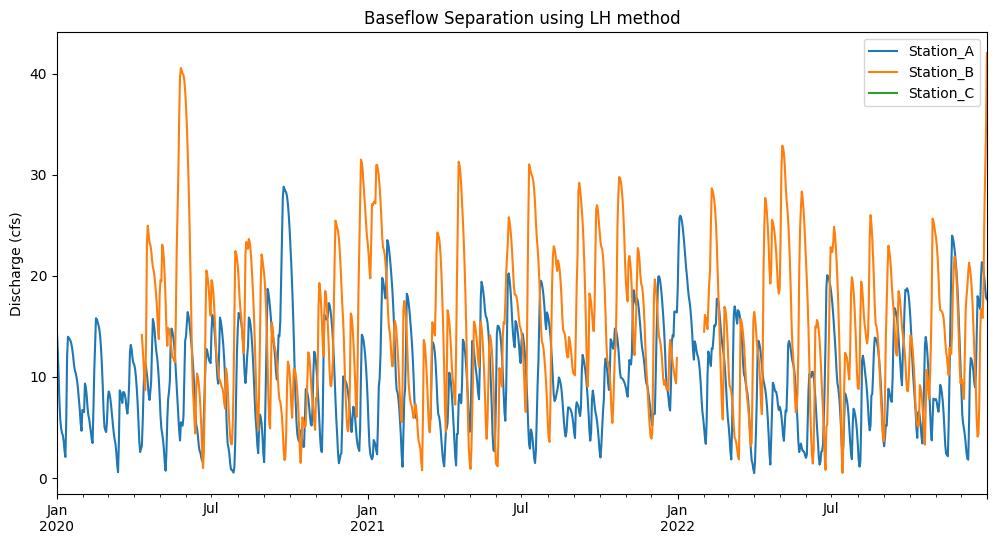

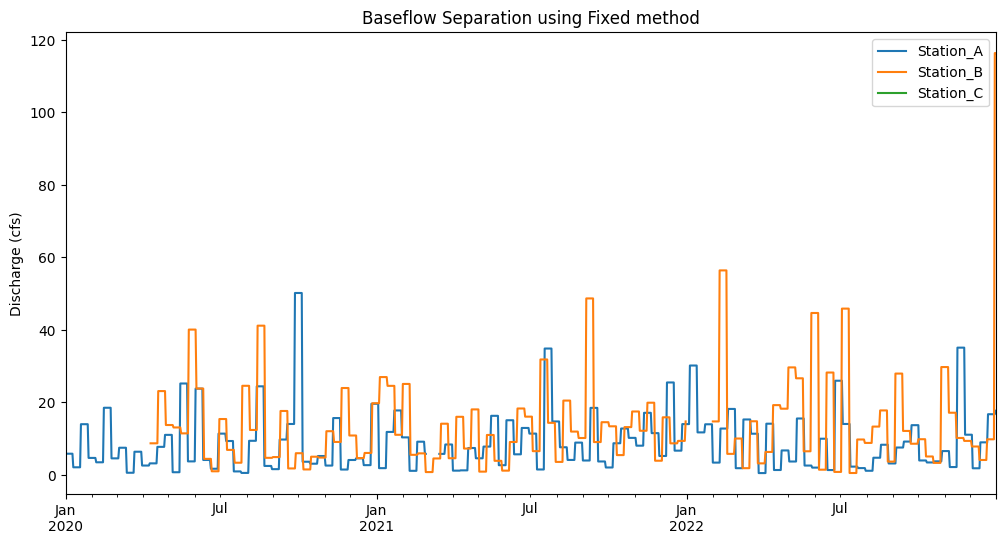

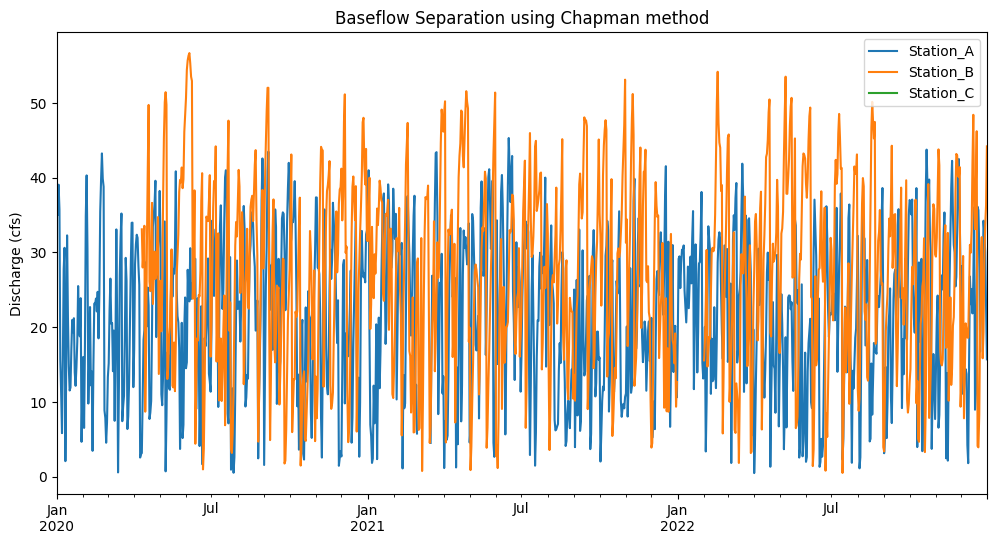

In [21]:
# Plot the results
for method in methods:
  fig, ax = plt.subplots(figsize=(12, 6))
  for station in result_dfs[method].columns:
    result_dfs[method][station].plot(ax=ax, label=station)
  ax.set_title(f'Baseflow Separation using {method} method')
  ax.set_ylabel('Discharge (cfs)')
  ax.legend()
  plt.show()
